In [1]:
from dataloader.dataloader import *
from PIL import Image

from model.model import ResNetAE_RGB
import os
import torch
import numpy as np
from skimage import io
from collections import OrderedDict
import trimesh

from utils.utils import get_peeled_intersections, get_rgb_peels, get_depth_peels, mesh_init
from utils.sceneflow import get_scf_peels
from utils.loss_utils import *
from utils.backproject import *
from torchvision import transforms
from pytorch3d.loss import chamfer_distance

In [2]:
root = '/home2/richa.mishra/4DReconstruction/cloth3d_goodseqs/03384'
out_dir = '/home2/richa.mishra/4DReconstruction/test'
mesh = mesh_init(root, 'Frame000', is_smpl=False)
mesh_next = mesh_init(root, 'Frame001', is_smpl=False)
#mesh.export(file_obj='/home2/richa.mishra/4DReconstruction/curr1.obj')
#mesh_next.export(file_obj = '/home2/richa.mishra/4DReconstruction/next1.obj')

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")
    
print(device)
model = ResNetAE_RGB()
checkpoint = torch.load('/home2/richa.mishra/4DReconstruction/code/checkpoint-epoch60.pth', map_location=torch.device('cpu'))
new_state_dict = OrderedDict()
for k, v in checkpoint['state_dict'].items():
    name = k[7:] # remove `module.`
    new_state_dict[name] = v
# load params
model.load_state_dict(new_state_dict)
model.eval()

cpu


ResNetAE_RGB(
  (encoder_rgb_curr): Encoder(
    (conv_list): ModuleList(
      (0): Sequential(
        (0): Conv2d(8, 16, kernel_size=(2, 2), stride=(2, 2))
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.2, inplace=True)
      )
      (1): Sequential(
        (0): Conv2d(16, 32, kernel_size=(2, 2), stride=(2, 2))
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.2, inplace=True)
      )
      (2): Sequential(
        (0): Conv2d(32, 64, kernel_size=(2, 2), stride=(2, 2))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.2, inplace=True)
      )
      (3): Sequential(
        (0): Conv2d(64, 128, kernel_size=(2, 2), stride=(2, 2))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): L

In [8]:
for keys, v in checkpoint['state_dict'].items():
    #print(v.shape)
    print(keys)

torch.Size([16, 8, 2, 2])
module.encoder_rgb_curr.conv_list.0.0.weight
torch.Size([16])
module.encoder_rgb_curr.conv_list.0.0.bias
torch.Size([16])
module.encoder_rgb_curr.conv_list.0.1.weight
torch.Size([16])
module.encoder_rgb_curr.conv_list.0.1.bias
torch.Size([16])
module.encoder_rgb_curr.conv_list.0.1.running_mean
torch.Size([16])
module.encoder_rgb_curr.conv_list.0.1.running_var
torch.Size([])
module.encoder_rgb_curr.conv_list.0.1.num_batches_tracked
torch.Size([32, 16, 2, 2])
module.encoder_rgb_curr.conv_list.1.0.weight
torch.Size([32])
module.encoder_rgb_curr.conv_list.1.0.bias
torch.Size([32])
module.encoder_rgb_curr.conv_list.1.1.weight
torch.Size([32])
module.encoder_rgb_curr.conv_list.1.1.bias
torch.Size([32])
module.encoder_rgb_curr.conv_list.1.1.running_mean
torch.Size([32])
module.encoder_rgb_curr.conv_list.1.1.running_var
torch.Size([])
module.encoder_rgb_curr.conv_list.1.1.num_batches_tracked
torch.Size([64, 32, 2, 2])
module.encoder_rgb_curr.conv_list.2.0.weight
torch

In [4]:
dataset_path = '/home2/richa.mishra/4DReconstruction/dataset/03384'
seq_ID = '03384'
rgb_path = os.path.join(dataset_path, 'rgb', seq_ID)
scf_path = os.path.join(dataset_path, 'scf', seq_ID)
depth_path = os.path.join(dataset_path, 'depth', seq_ID)

trsfm_rgb = transforms.Normalize(mean=[127.5, 127.5, 127.5], std=[127.5, 127.5, 127.5])
trsfm_scf = transforms.Normalize(mean=[-0.3]*12, std=[0.6]*12)

rgb1_rgb2_scf = []

curr_rgb1_img = io.imread(os.path.join(rgb_path,'Frame000', 'rgb_01.png'))
curr_rgb2_img = io.imread(os.path.join(rgb_path,'Frame000', 'rgb_02.png'))
curr_rgb3_img = io.imread(os.path.join(rgb_path,'Frame000', 'rgb_03.png'))
curr_rgb4_img = io.imread(os.path.join(rgb_path,'Frame000', 'rgb_04.png'))
next_rgb1_img = io.imread(os.path.join(rgb_path,'Frame001', 'rgb_01.png'))

curr_rgb1 = (torch.from_numpy(np.array(curr_rgb1_img))).float().permute(2,0,1)
curr_rgb2 = (torch.from_numpy(np.array(curr_rgb2_img))).float().permute(2,0,1)
curr_rgb3 = (torch.from_numpy(np.array(curr_rgb3_img))).float().permute(2,0,1)
curr_rgb4 = (torch.from_numpy(np.array(curr_rgb4_img))).float().permute(2,0,1)
curr_rgb1 = trsfm_rgb(curr_rgb1)
curr_rgb2 = trsfm_rgb(curr_rgb2)
curr_rgb3 = trsfm_rgb(curr_rgb3)
curr_rgb4 = trsfm_rgb(curr_rgb4)
next_rgb1 = (torch.from_numpy(np.array(next_rgb1_img))).float().permute(2,0,1)
next_rgb1 = trsfm_rgb(next_rgb1)

"""scf"""

scf_path = os.path.join(scf_path, 'Frame000')

scf_arr1 = np.load(os.path.join(scf_path, 'scf_1.npz'))
scf_arr2 = np.load(os.path.join(scf_path, 'scf_2.npz'))
scf_arr3 = np.load(os.path.join(scf_path, 'scf_3.npz'))
scf_arr4 = np.load(os.path.join(scf_path, 'scf_4.npz'))
scf = np.concatenate([scf_arr1.f.a, scf_arr2.f.a, scf_arr3.f.a, scf_arr4.f.a], axis=2) # BxWx12
scf_gt = scf
scf = torch.Tensor(scf).permute(2,0,1)

scf = trsfm_scf(scf)
print(scf.shape)
output_frame = torch.cat([curr_rgb1, curr_rgb2, curr_rgb3, curr_rgb4, next_rgb1, scf], dim=0) # 18xBxW
print(output_frame.shape)

torch.Size([12, 512, 512])
torch.Size([27, 512, 512])


In [5]:
output_scf = model(output_frame.unsqueeze(0))
output_scf = output_scf*0.6 - 0.3
next_rgb1 = next_rgb1*127.5 + 127.5
output_scf.shape

torch.Size([1, 12, 512, 512])

torch.Size([12, 512, 512])


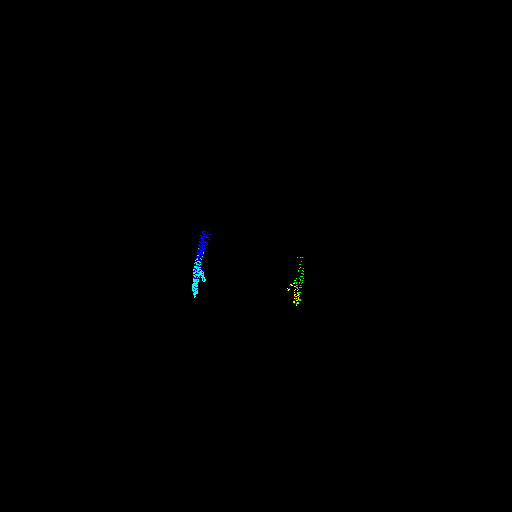

In [6]:
root = '/home2/richa.mishra/4DReconstruction/cloth3d_goodseqs/03384'
out_dir = '/home2/richa.mishra/4DReconstruction/test'
intersections, ray_param, ray_intersect_param, scene = get_peeled_intersections(root, 'Frame000', is_smpl=False)
intersections2, ray_param2, ray_intersect_param2, scene2 = get_peeled_intersections(root, 'Frame001', is_smpl=False)
#scf_gt = scf_gt.permute(1,2,0)
depth_curr, _ = get_depth_peels(root, 'Frame000', intersections, ray_param, ray_intersect_param, scene, out_dir, is_smpl=False)
depth_next, _ = get_depth_peels(root, 'Frame001', intersections2, ray_param2, ray_intersect_param2, scene2, out_dir, is_smpl=False)
scf_image1 = Image.fromarray((np.uint8(scf_gt[:,:,3:6]*500))).convert('RGB')
print(scf.shape)
#print(depth_curr.shape)
scf_image1


torch.Size([512, 512, 3])
torch.Size([512, 512, 12])


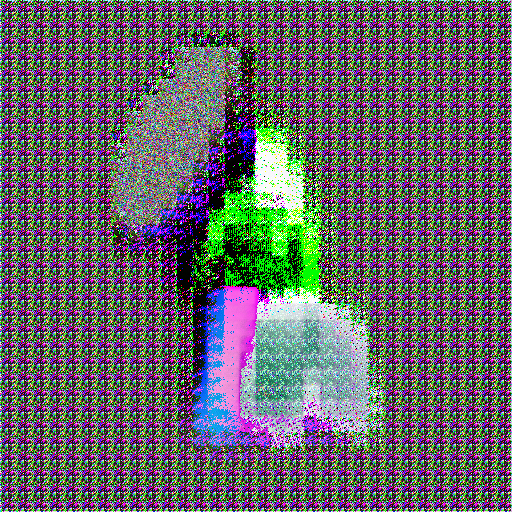

In [17]:
mask = torch.where(torch.tensor(depth_curr[2])>0)
y, x = mask
mask_a = torch.zeros(512,512,3)
mask_a[y,x,:] = 1
print(mask_a.shape)

scf_pred = output_scf.clone().detach().squeeze().permute(1,2,0)
scf_image1 = Image.fromarray((np.uint8(scf_pred[:,:,:3]*500))).convert('RGB')
print(scf_pred.shape)
scf_image1

torch.Size([512, 512, 12])


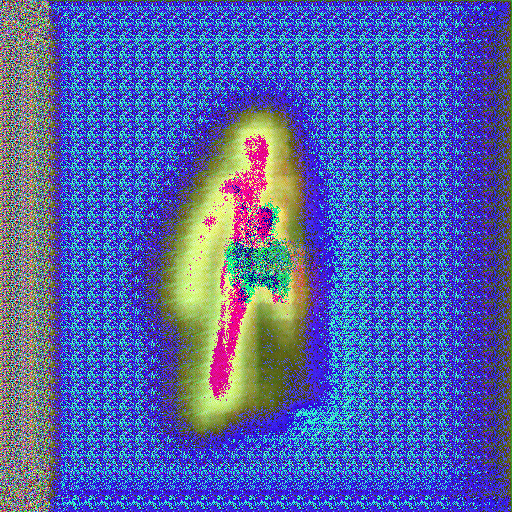

In [8]:
scf_pred = output_scf.clone().detach().squeeze().permute(1,2,0)
scf_image1 = Image.fromarray(np.uint8(scf_pred[:,:,:3]*500)).convert('RGB')
print(scf_pred.shape)
scf_image1

In [8]:
torch.max(scf_pred), torch.min(scf_pred), np.max(scf_gt), np.min(scf_gt)

(tensor(28.9634), tensor(-53.2058), 0.017047672, -0.019039737)

In [ ]:
torch.sum(scf1_gt.ravel() - scf_pred.ravel())

AttributeError: 'list' object has no attribute 'shape'

In [9]:
print(output_scf.shape)
depth_curr = torch.tensor(depth_curr)#.cuda()
depth_next1 = torch.tensor(depth_next)#.cuda() 
points_next_pred = project_fullbody_pred(output_scf.squeeze(0), depth_curr)
point_next_gt = project_fullbody(depth_next1)
dist = chamfer_distance(point_next_gt.unsqueeze(0), points_next_pred.unsqueeze(0))
points_next_pred = points_next_pred.detach().cpu().numpy()
point_next_gt = point_next_gt.detach().cpu().numpy()
print(points_next_pred.shape, point_next_gt.shape)

torch.Size([1, 12, 512, 512])
(32037, 3) (32003, 3)


In [13]:
torch.sum(scf1.ravel() - output_scf.ravel())

NameError: name 'scf1' is not defined

In [13]:
dist

(tensor(0.0003, grad_fn=<AddBackward0>), None)

In [10]:
K = np.array([[443.40500674,   0.        , 256.],
              [  0.        , 443.40500674, 256.],
              [  0.        ,   0.        ,   1.]])

K = torch.tensor(K).float()

rotate_1 = trimesh.transformations.rotation_matrix(angle=np.radians(90), direction=[0, 0, -1])
rotate_2 = trimesh.transformations.rotation_matrix(angle=np.radians(180), direction=[0,-1,0])
EXTRINSIC = torch.tensor(rotate_1[:3, :3] @ rotate_2[:3, :3]).float()
extrinsic = EXTRINSIC

In [ ]:
x, y = torch.meshgrid(torch.arange(0, depth_curr[0].shape[1]),
                      torch.arange(0, depth_curr[0].shape[0]))

x = x.reshape(-1)
y = y.reshape(-1)
ones = torch.ones_like(x)
im_points = torch.stack((y, x, ones), 0).float()
K = torch.tensor(K).float()

world_points = ((torch.linalg.inv(extrinsic) @ torch.linalg.inv(K) @ im_points) * depth_curr[0].cpu().reshape(-1)).cpu().numpy()
world_points_next_gt = ((torch.linalg.inv(extrinsic) @ torch.linalg.inv(K) @ im_points) * depth_next[0].reshape(-1)).cpu().numpy()
#world_points = (torch.linalg.inv(K) @ (im_points * smpl_depth_curr[0].reshape(-1))).cpu().numpy()
#world_points_next = (world_points.T + output_scf[0:3,:,:].reshape(-1, 3)).T
#im_points_next = K @ extrinsic @ world_points_next

In [ ]:
K.device

In [11]:
mesh_folder = "/home2/richa.mishra/4DReconstruction"
obj3 = open(mesh_folder + '/pred_rgb3_60_test.obj', 'w+')
for vert in points_next_pred:
    obj3.write('v ' + str(vert[0]) + ' ' + str(vert[1]) + ' ' + str(vert[2]) 
               + ' 0 0 255 \n')
    
obj3.close()

In [43]:
mesh_folder = "/home2/richa.mishra/4DReconstruction"
obj3 = open(mesh_folder + '/gt_1_test.obj', 'w+')
for vert in point_next_gt:
    obj3.write('v ' + str(vert[0]) + ' ' + str(vert[1]) + ' ' + str(vert[2]) 
               + ' 0 0 255 \n')
    
obj3.close()

In [ ]:
im_points_next = K @ extrinsic @ points_next_pred.T
u, v = im_points_next[:2, :]/ im_points_next[2, :]
mask = torch.where(im_points_next[2, :] != 0)[0]

u = torch.round(u[mask]).int()
v = torch.round(v[mask]).int()

print(torch.max(v), torch.min(v))
print(torch.max(u), torch.min(u))

depth = -im_points_next[2,mask]
#print(torch.sum(masku[0] == maskv[0]))
im_next = torch.zeros(512, 512)
for i in range(len(mask)):

    im_next[u[i], v[i]] = depth[i]
    
diff_img = Image.fromarray(np.uint8(im_next*100)).convert('RGB')
diff_img    

In [3]:
dataset_path = '/home2/richa.mishra/4DReconstruction/dataset'
seq_ID = '00491'

In [4]:
dataloader = TemporalDataloader(dataset_path, seq_ID, K_frames=2, 
                               batch_size = 1, shuffle=True)

In [5]:
len(dataloader)

2

In [6]:
for idx, d in enumerate(dataloader):
    print("idx = "+str(idx))
    rgb, dep1, dep2 = d
    print(rgb.shape)
    print(dep1.shape)
    B, K, C, H, W = rgb.shape
    B, K, n_peels, H, W = dep1.shape
    
    dep1 = dep1.reshape(B*K, n_peels, H, W)
    rgb = rgb.reshape(B*K, H, W, C)
    print(rgb.shape)
    print(dep1.shape)

    
    #print(d[0][1].shape)

max: tensor(0.0706) min: tensor(-0.0268)
max: tensor(0.8043) min: tensor(0.1545)
max: tensor(0.0751) min: tensor(-0.0269)
max: tensor(0.8340) min: tensor(0.1538)
max: tensor(0.0751) min: tensor(-0.0269)
idx = 0
torch.Size([1, 2, 18, 512, 512])
torch.Size([1, 2, 4, 512, 512])
torch.Size([2, 512, 512, 18])
torch.Size([2, 4, 512, 512])
max: tensor(0.8340) min: tensor(0.1538)
max: tensor(0.0712) min: tensor(-0.0241)
max: tensor(0.8082) min: tensor(0.1725)
idx = 1
torch.Size([1, 2, 18, 512, 512])
torch.Size([1, 2, 4, 512, 512])
torch.Size([2, 512, 512, 18])
torch.Size([2, 4, 512, 512])


In [ ]:
dep1[0][1].shape

In [ ]:
rgb1 = rgb[0, :, :, 3:6]
rgb2 = rgb[1, :, :, :3]
image1 = Image.fromarray((np.uint8(rgb1))).convert('RGB')
image2 = Image.fromarray((np.uint8(rgb2))).convert('RGB')

image1

In [ ]:
image2

In [ ]:
#Batch0, 
dep11 = dep1[0][2][0]
dep12 = dep2[0][1][0]
image1 = Image.fromarray((np.uint8(dep11)*90)).convert('RGB')
image2 = Image.fromarray((np.uint8(dep12)*90)).convert('RGB')

image1

In [ ]:
image2

In [ ]:
from model.loss import depth_L1_loss
import numpy as np
import torch
import os

In [ ]:
root = '/home2/richa.mishra/4DReconstruction/dataset'

scf_arr1 = np.load(os.path.join(root, 'scf/00491/Frame000', 'scf_1.npz'))
scf_arr2 = np.load(os.path.join(root, 'scf/00491/Frame000', 'scf_2.npz'))
scf_arr3 = np.load(os.path.join(root, 'scf/00491/Frame000', 'scf_3.npz'))
scf_arr4 = np.load(os.path.join(root, 'scf/00491/Frame000', 'scf_4.npz'))
scf = np.concatenate([scf_arr1.f.a, scf_arr2.f.a, scf_arr3.f.a, scf_arr4.f.a], axis=2) # BxWx12

scf = torch.Tensor(scf)


curr_dep_arr1 = np.load(os.path.join(root, 'depth/00491/Frame000', 'dep_1.npz'))
curr_dep_arr2 = np.load(os.path.join(root, 'depth/00491/Frame000', 'dep_2.npz'))
curr_dep_arr3 = np.load(os.path.join(root, 'depth/00491/Frame000', 'dep_3.npz'))
curr_dep_arr4 = np.load(os.path.join(root, 'depth/00491/Frame000', 'dep_4.npz'))
curr_dep = np.stack([curr_dep_arr1.f.a, curr_dep_arr2.f.a,
                     curr_dep_arr3.f.a, curr_dep_arr4.f.a]) #4xWxH
curr_dep = torch.Tensor(curr_dep)


next_dep_arr1 = np.load(os.path.join(root, 'depth/00491/Frame001', 'dep_1.npz'))
next_dep_arr2 = np.load(os.path.join(root, 'depth/00491/Frame001', 'dep_2.npz'))
next_dep_arr3 = np.load(os.path.join(root, 'depth/00491/Frame001', 'dep_3.npz'))
next_dep_arr4 = np.load(os.path.join(root, 'depth/00491/Frame001', 'dep_4.npz'))
next_dep = np.stack([next_dep_arr1.f.a, next_dep_arr2.f.a,
                     next_dep_arr3.f.a, next_dep_arr4.f.a]) #4xWxH
next_dep = torch.Tensor(next_dep)

In [12]:
def gridsample(input1, input2):
    #if self.opt.fp16: # not sure if it's necessary
        #return grid_sample(input1.float(), input2.float(), mode='bilinear', padding_mode='border').half()
    #else:
    return grid_sample(input1, input2, mode='bilinear', padding_mode='zeros')

In [14]:
x, y = torch.meshgrid(torch.arange(0, depth_curr[0].shape[1]),
                      torch.arange(0, depth_curr[0].shape[0]))

x = x.reshape(-1)
y = y.reshape(-1)
ones = torch.ones_like(x)
im_points = torch.stack((y, x, ones), 0).float()
K = torch.tensor(K).float()

world_points = ((torch.linalg.inv(extrinsic) @ torch.linalg.inv(K) @ im_points) * depth_curr[0].reshape(-1))#.cpu().numpy()
#world_points_next_gt = ((torch.linalg.inv(extrinsic) @ torch.linalg.inv(K) @ im_points) * smpl_depth_next[0].reshape(-1)).cpu().numpy()
#world_points = (torch.linalg.inv(K) @ (im_points * smpl_depth_curr[0].reshape(-1))).cpu().numpy()
world_points_next = (world_points.T + scf_pred[:,:,:3].reshape(-1, 3)).T
im_points_next = K @ extrinsic @ world_points_next

u, v = im_points_next[:2, :]/ (im_points_next[2, :])
u = (u.reshape(1, 512, 512).unsqueeze(0))
v = (v.reshape(1, 512, 512).unsqueeze(0))
print(u.shape, torch.min(u), torch.max(u), torch.min(v), torch.max(v), 
      torch.max(im_points_next[2,:]), torch.min(im_points_next[2,:]),
      #np.max(depth_curr[0]), np.min(depth_curr[0])
     )

print(torch.max(scf_pred), torch.min(scf_pred))

flow = torch.cat([u, v], dim=1)
print(flow.shape)

#mx = torch.max(flow)
#mn = torch.min(flow)
#scf1 = (2*(flow)-mn -mx)/(mx-mn)
scf1 = (2*(flow)-511)/511
print(torch.max(scf1), torch.min(scf1))

final_grid = (scf1).permute(0, 2, 3, 1)
print(final_grid.shape)
output = gridsample(next_rgb1.unsqueeze(0), final_grid)

torch.Size([1, 1, 512, 512]) tensor(-4404699.5000) tensor(65133012.) tensor(-9554330.) tensor(24904292.) tensor(11.1049) tensor(-4.9366)
tensor(28.9634) tensor(-53.2058)
torch.Size([1, 2, 512, 512])
tensor(254922.7188) tensor(-37395.6406)
torch.Size([1, 512, 512, 2])


In [15]:
torch.max(output[0,:,:,:]), torch.min(output[0,:,:,:])

(tensor(254.7723), tensor(0.))

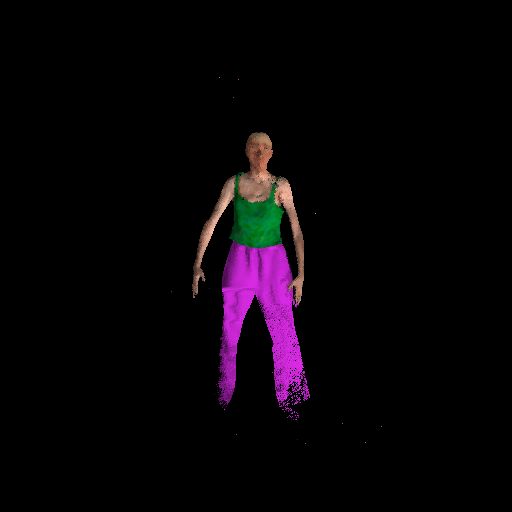

In [16]:
image1 = Image.fromarray((np.uint8(output[0,:,:,:].permute(1,2,0)))).convert('RGB')
#image1.save(out_dir + '/' + 'rgb_01_frame2.png')
image1